In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.base import BaseEstimator, TransformerMixin

warnings.filterwarnings('ignore')

               value
2020-01-01  0.248357
2020-01-02 -0.053354
2020-01-03  0.355397
2020-01-04  0.808834
2020-01-05 -0.054003
...              ...
2020-07-14  0.257322
2020-07-15 -0.393019
2020-07-16  0.110007
2020-07-17  0.046475
2020-07-18 -0.569892

[200 rows x 1 columns]


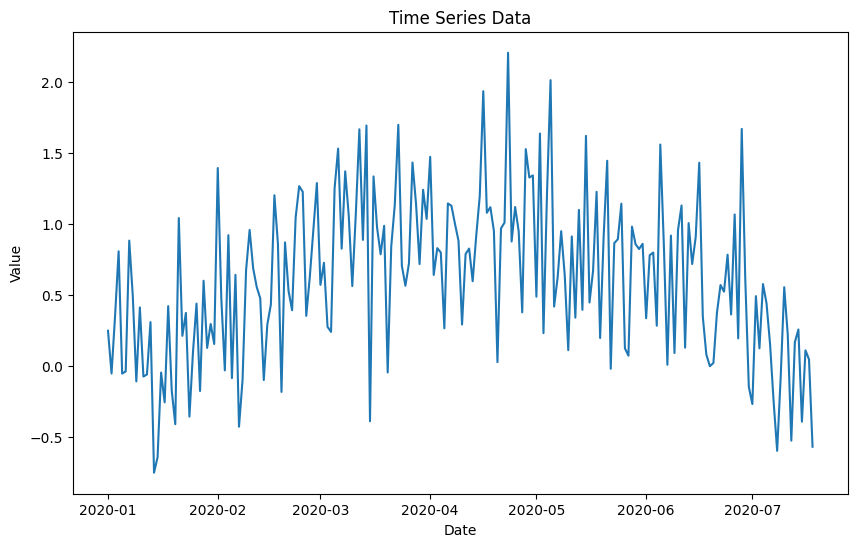

In [2]:
# 예시 데이터 생성 (임의의 일변량 시계열 데이터)
np.random.seed(42)
date_range = pd.date_range(start='1/1/2020', periods=200, freq='D')
data = np.sin(np.linspace(0, 3.14, 200)) + np.random.normal(scale=0.5, size=200)
time_series_data = pd.DataFrame(data, index=date_range, columns=['value'])

print(time_series_data)

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(time_series_data)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [3]:
# LSTM 모델에 입력될 데이터 형식 준비
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

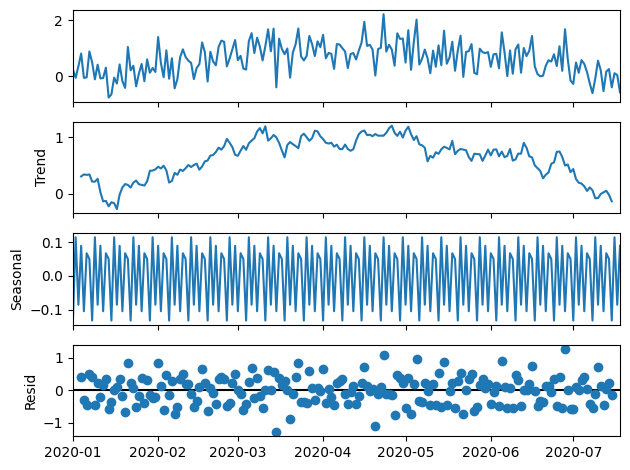

In [4]:
# 시계열 분해
result = seasonal_decompose(time_series_data, model='additive')
result.plot()
plt.show()

# 데이터 전처리: MinMax Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data)

In [5]:
time_step = 10
X, Y = create_dataset(scaled_data, time_step)

# 데이터 차원 변경: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X, Y, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
189/189 [==============================] - 2s 2ms/step - loss: 0.0364
Epoch 2/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 3/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 4/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 5/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 6/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 7/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0334
Epoch 8/300
189/189 [==============================] - 0s 3ms/step - loss: 0.0303
Epoch 9/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 10/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 11/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0306
Epoch 12/300
189/189 [==============================] - 0s 2ms/step - loss: 0.0298
Epoch 13/300


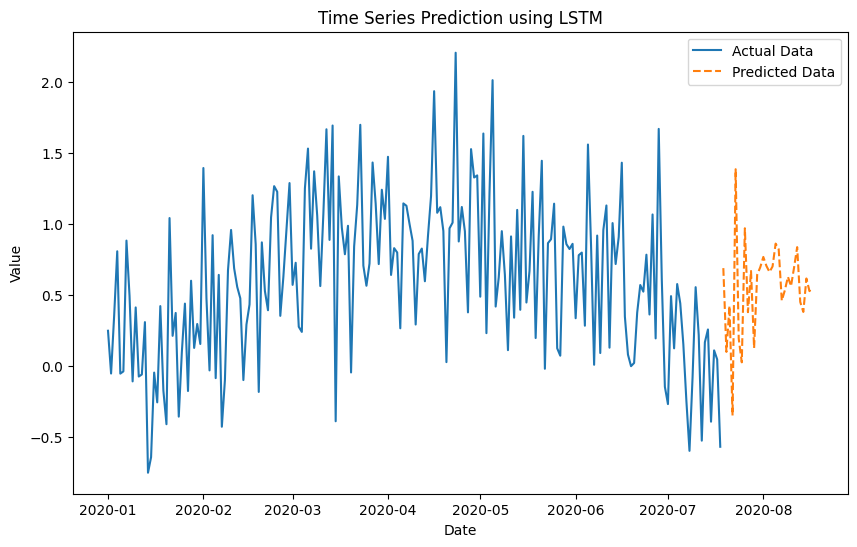

In [6]:
# 미래 데이터 예측
pred_count = 30  # 예측할 미래 시간대의 수
input_seq = scaled_data[-time_step:]  # 가장 최근의 입력 시퀀스
predictions = []

for _ in range(pred_count):
    input_seq = input_seq.reshape((1, time_step, 1))
    predicted_value = model.predict(input_seq, verbose=0)
    predictions.append(predicted_value[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

# 원래 스케일로 되돌리기
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 예측 결과 시각화
future_dates = pd.date_range(start=time_series_data.index[-1] + pd.Timedelta(days=1), periods=pred_count, freq='D')
predicted_series = pd.DataFrame(predictions, index=future_dates, columns=['value'])

plt.figure(figsize=(10, 6))
plt.plot(time_series_data, label='Actual Data')
plt.plot(predicted_series, label='Predicted Data', linestyle='--')
plt.title('Time Series Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [9]:
values = X  # 예시 데이터

# BaseEstimator : 추정기 객체를 생성할 때 전달된 하이퍼파라미터를 저장하고 관리하는 기능 제공. 
# TransformerMixin : 변환기 클래스를 위한 믹스인 클래스. fit_transorm 을 상속받음으로서 변환기 인터페이스를 일관되게 유지할 수 있음
class MissingValueRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            # 2차원 또는 3차원 배열 처리
            if X.ndim == 2:
                return X[~np.isnan(X).any(axis=1)]
            elif X.ndim == 3:
                return X[~np.isnan(X).any(axis=(1, 2))]
        else:
            raise ValueError("Input should be a numpy array")

# 시계열 데이터 정규화 변환기
class TimeSeriesScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
        
    def fit(self, X, y=None):
        # 2차원으로 변환 후 피팅
        n_samples, n_steps, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        self.scaler.fit(X_reshaped)
        return self
    
    def transform(self, X):
        # 2차원으로 변환 후 변환 적용
        n_samples, n_steps, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        X_scaled = self.scaler.transform(X_reshaped)
        # 원래 차원으로 다시 변환
        return X_scaled.reshape(n_samples, n_steps, n_features)
    
    def inverse_transform(self, X):
        # 2차원으로 변환 후 역변환 적용
        n_samples, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        X_inversed = self.scaler.inverse_transform(X_reshaped)
        return X_inversed.reshape(n_samples, n_features)

# LSTM 입력 형태 변환 함수
def reshape_lstm_input(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# LSTM 모델 빌드 함수
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 파이프라인 구성
n_steps = 10

pipeline = Pipeline([
    ('missing_value_remover', MissingValueRemover()),
    ('normalizer', TimeSeriesScaler()),
    ('regressor', KerasRegressor(model=build_lstm_model, input_shape=(n_steps, 1), epochs=300, batch_size=1))
])

Epoch 1/300
1880/1880 [==============================] - 5s 2ms/step - loss: 0.0282
Epoch 2/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0167
Epoch 3/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0095
Epoch 4/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0073
Epoch 5/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0068
Epoch 6/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0066
Epoch 7/300
1880/1880 [==============================] - 5s 2ms/step - loss: 0.0062
Epoch 8/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0062
Epoch 9/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0063
Epoch 10/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0060
Epoch 11/300
1880/1880 [==============================] - 4s 2ms/step - loss: 0.0059
Epoch 12/300
1880/1880 [==============================] - 4s 2ms/step - lo

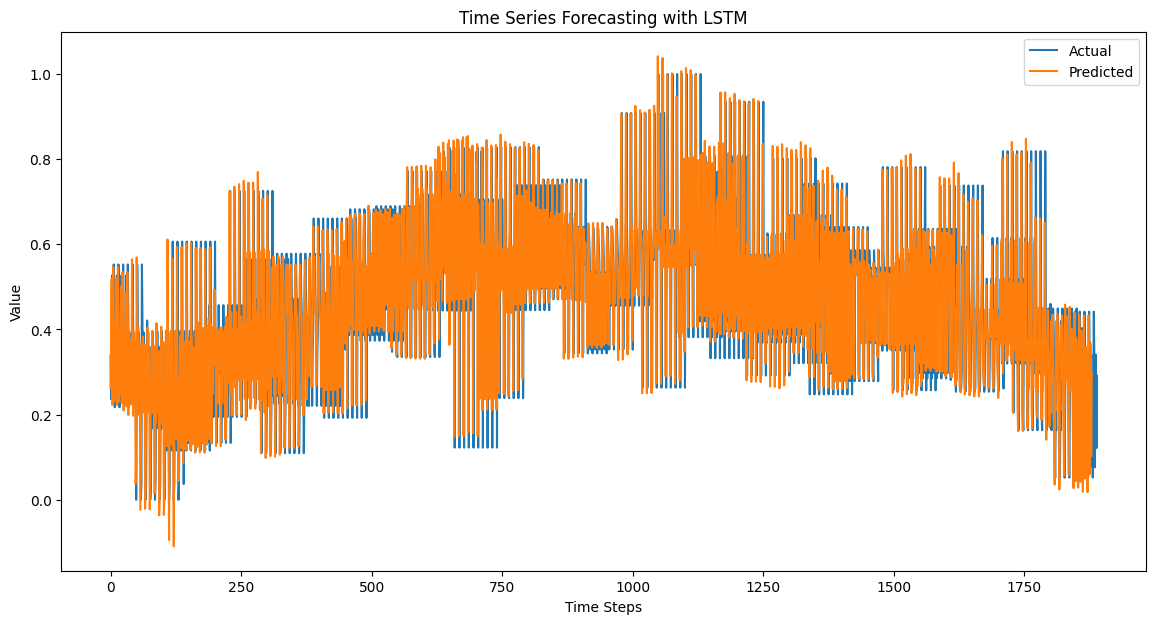

In [11]:
# 데이터 재구성
values = values.reshape(-1, 1)  # 단변량 시계열 데이터는 2D 배열이어야 함
X_lagged, y_lagged = reshape_lstm_input(values, n_steps)
X_lagged = X_lagged.reshape(X_lagged.shape[0], X_lagged.shape[1], 1)  # LSTM 입력 형태로 변환

# 전처리된 데이터로 파이프라인 학습
pipeline.fit(X_lagged, y_lagged)

# 예측
predictions = pipeline.named_steps['regressor'].predict(X_lagged, verbose=0)

# 예측값 역정규화
predictions = pipeline.named_steps['normalizer'].inverse_transform(predictions.reshape(-1, 1))
# print(predictions)

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Time Series Forecasting with LSTM')
plt.legend()
plt.show()